In [1]:
import numpy as np
import cv2
import json
import os
import yaml
import torch
import pdb
import open3d as o3d
import matplotlib.pyplot as plt
import torch
%matplotlib inline

calib_folder = './calibration'
global_config = os.path.join(calib_folder, 'defaults.yaml')
camera_config = os.path.join(calib_folder, 'cameras.yaml')
with open(global_config) as f:
    global_config_dict = yaml.safe_load(f)

with open(camera_config) as f:
    camera_config_dict = yaml.safe_load(f)

def cart2hom(pts_3d: np.array) -> np.array:
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
    return pts_3d_hom

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

TRAIN =[
    'bytes-cafe-2019-02-07_0',
    'clark-center-2019-02-28_0',
    'clark-center-2019-02-28_1',
    'clark-center-intersection-2019-02-28_0',
    'cubberly-auditorium-2019-04-22_0',
    'forbes-cafe-2019-01-22_0',
    'gates-159-group-meeting-2019-04-03_0',
    'gates-ai-lab-2019-02-08_0',
    'gates-basement-elevators-2019-01-17_1',
    'gates-to-clark-2019-02-28_1',
    'hewlett-packard-intersection-2019-01-24_0',
    'huang-2-2019-01-25_0',
    'huang-basement-2019-01-25_0',
    'huang-lane-2019-02-12_0',
    'jordan-hall-2019-04-22_0',
    'memorial-court-2019-03-16_0',
    'meyer-green-2019-03-16_0',
    'nvidia-aud-2019-04-18_0',
    'packard-poster-session-2019-03-20_0',
    'packard-poster-session-2019-03-20_1',
    'packard-poster-session-2019-03-20_2',
    'stlc-111-2019-04-19_0',
    'svl-meeting-gates-2-2019-04-08_0',
    'svl-meeting-gates-2-2019-04-08_1',
    'tressider-2019-03-16_0',
    'tressider-2019-03-16_1',
    'tressider-2019-04-26_2'
]
sensor = "sensor_0"
lidar = "upper"
data_root = "/home/tho/datasets/JRDB2022/train_dataset_with_activity"


In [11]:
with open('calibration/lidars.yaml') as f:
    lidar_calib = yaml.safe_load(f)

In [18]:
translation = {
    "sensor_8": {"ego2indi":{"T": torch.tensor([0,0,0]), "theta": 0*np.pi}},
    "sensor_6": {"ego2indi":{"T": torch.tensor([0,0,0]), "theta": 0*np.pi}},
    "sensor_4": {"ego2indi":{"T": torch.tensor([0,0,0]), "theta": 0*np.pi}},
    "sensor_2": {"ego2indi":{"T": torch.tensor([0,0,0]), "theta": 0*np.pi}},
    "sensor_0": {"ego2indi":{"T": torch.tensor([0,0,0]), "theta": 0*np.pi}},
}

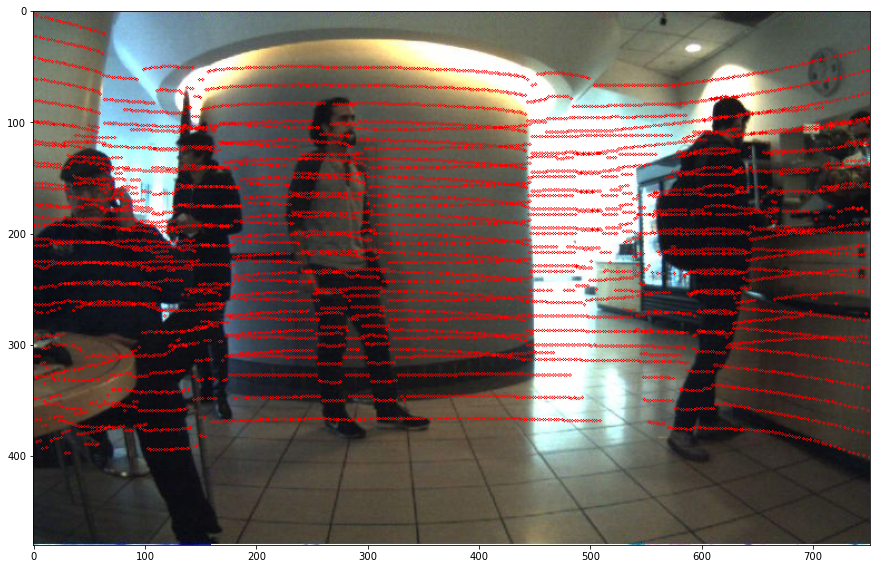

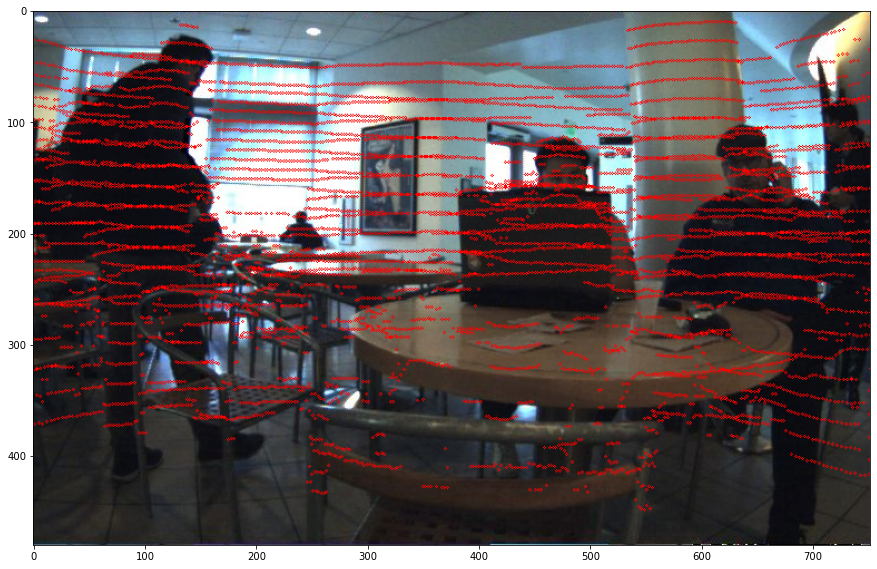

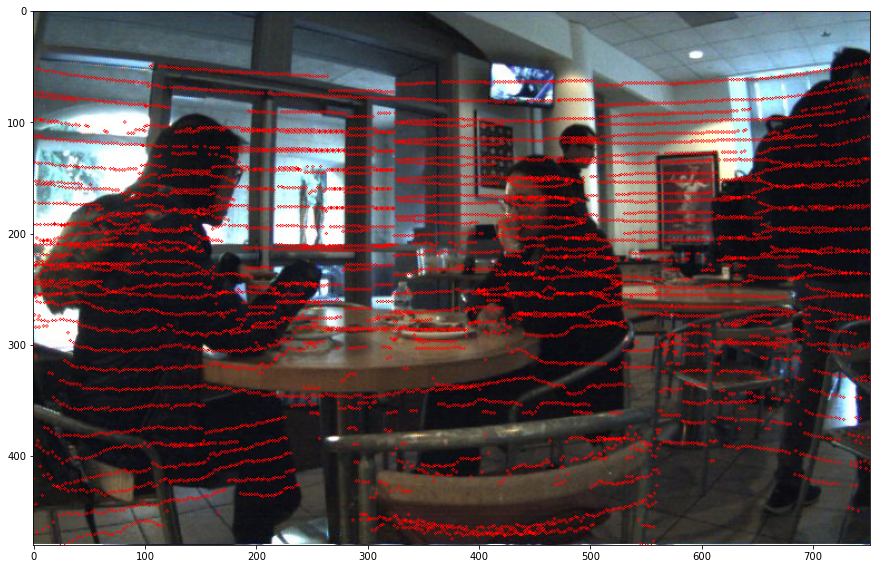

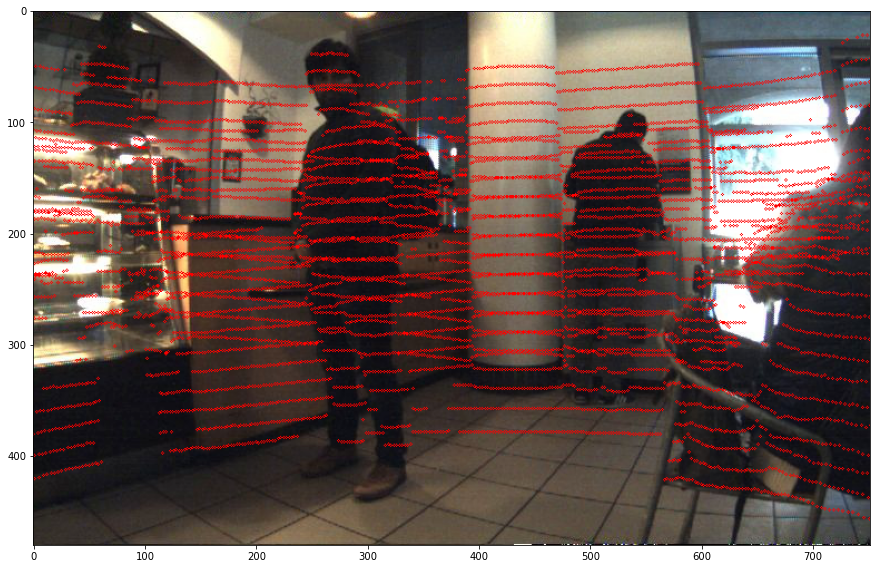

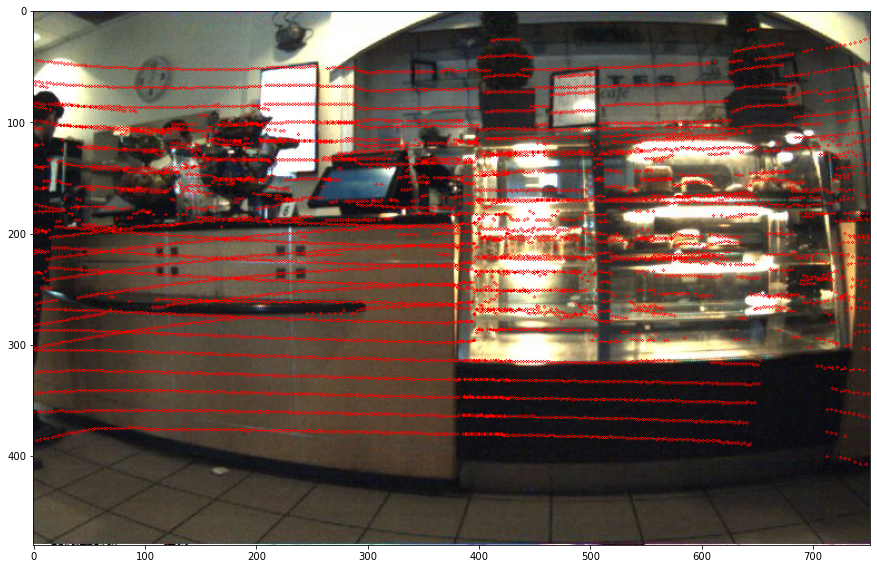

In [19]:
sensor = 'sensor_8'
for sensor in translation.keys():
    for i, loc in enumerate(TRAIN):
        all_pts_2d = None
        all_points = None
        # merge lidars
        for lidar in ['upper','lower']:
            pcd = o3d.io.read_point_cloud(f"{data_root}/pointclouds/{lidar}_velodyne/{loc}/000000.pcd")
            points_3d = np.array(pcd.points)
            hom_points = cart2hom(points_3d)
            lidar2ego = np.array(lidar_calib[lidar]['lidar2ego'])
            ego_points = np.dot(lidar2ego, np.transpose(hom_points))
            if all_points is not None:
                all_points = np.hstack([all_points, ego_points])
            else:
                all_points = ego_points
        ego2cam = np.array(lidar_calib[sensor]['ego2cam'])


#         lidar2indi = translation[sensor][f'ego2indi']
#         trans = lidar2indi['T'].reshape([3,1])
#         t = lidar2indi['theta']
#         rots = np.zeros([4,4])
#         c = np.cos(t)
#         s = np.sin(t)
#         rots = [[c,-s, 0],
#                 [s, c, 0],
#                 [0, 0, 1]]
#         new_RT = np.vstack([np.hstack([rots, trans]),[0,0,0,1]])

#         ego2cam = ego2cam.dot(new_RT)
        lidar_calib[sensor]['ego2cam'] = ego2cam.tolist()


        pts_ref = ego2cam.dot(all_points)
        pts_ref = np.transpose(pts_ref)
        pts_ref = pts_ref[pts_ref[:,2]>0]

        # Normalize
        x, y = pts_ref[:,0]/pts_ref[:,2], pts_ref[:,1]/pts_ref[:,2]

        # Calculate radial distortion
        k1,k2,k3,k4,k5 = lidar_calib[sensor]['D']
        k6 = 0

        r2 = x**2 + y**2
        r4 = r2**2
        r6 = r2 * r4
        rad_dist = (1 + k1*r2 + k2*r4 + k3*r6) 
        # Get intrinsics params
        K = lidar_calib[sensor]['K']
        fx, _, cx = K[0]
        _, fy, cy = K[1]
        # Apply radial distortion and intrinsic parameters
        xd = fx * x * rad_dist + cx
        yd = fy * y * rad_dist + cy
        # Get the 2D points
        pts_2d = np.stack([xd,yd]).transpose()

        if all_pts_2d is not None:
            all_pts_2d = np.vstack([all_pts_2d, pts_2d])
        else:
            all_pts_2d = pts_2d

        image = cv2.imread(f"{data_root}/images/image_{sensor[-1]}/{loc}/000000.jpg")
        plt.figure(figsize=(15, 10))
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        for pts in all_pts_2d:
            if (0<pts[0]<1000) and (0<pts[1]<1000):
                cv2.circle(hsv_image, (int(pts[0]), int(pts[1])), 1, (0, 255, 255), 1)
        hsv_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
        plt.imshow(hsv_image)
        break
    


In [ ]:
import sys
import ruamel.yaml
yaml = ruamel.yaml.YAML()
yaml.version = (1,2)
yaml.default_flow_style = None

with open('calibration/lidars.yaml', 'w') as outfile:
    yaml.dump(lidar_calib, outfile)
    
import yaml   